# Lombard lending: Modeling lending values

Based on Juri (2014), Lending Values and Liquidity Risk

Applied Credit Risk Modeling Seminar FS2021

Hubert Mrugala and Wenqi Li

# --- Modeling lending values ---

## Packages, functions and the data

In [1]:
# Loading packages
import numpy as np
import pandas as pd
import datetime
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels
import scipy.stats as st

# Calculate log returns
def log_returns(prices):
    return np.log(prices/prices.shift(1))

def ADTV(volumes):
    adtv = pd.DataFrame(data=[volumes.iloc[-20:,:].mean(),
                              volumes.iloc[-250*3:,:].mean()],
                        index=['ADTV - Last month','ADTV - Last three years']) \
                        .transpose()
    return adtv

# ---------------------------------

def mean(log_prices):
    return log_prices.mean()

def std(log_prices):
    return log_prices.std()

def annualized_volatility(log_prices):
    return log_prices.std() * np.sqrt(252)

# ---------------------------------

# Return drift and diffusion used to model the asset price process
def GBM(log_prices):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = (mu-sigma**2/2)*delta
    diffusion = sigma**2*delta
    return drift, diffusion

# Lending Value (not adjusted)
def LV(log_prices,alpha,epsilon,delta):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv = ( (1-alpha)*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv

def beta(log_prices):
    alpha = 0.25
    epsilon = 0.01
    delta = 10
    lv = LV(log_prices, alpha, epsilon, delta)
    beta = 1-(1-lv)*alpha
    ratio = lv/beta
    return beta

# Estimate gamma by using ADTV
def gamma_est(ADTV,a_hat,b_hat):
    return 10**a_hat*ADTV**b_hat

# Lending Value adjusted for liquidity
def LV_adj(log_prices,alpha,epsilon,delta,gamma,x):
    mu = mean(log_prices)
    sigma = std(log_prices)
    drift = GBM(log_prices)[0]
    diffusion = GBM(log_prices)[1]
    lv_adj = ( (1-alpha)*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) ) / \
    ( 1-alpha*(np.exp(-gamma*x+drift+sigma*np.sqrt(delta)*st.norm.ppf(epsilon))) )
    return lv_adj

def lvx(log_returns,alpha,epsilon,delta,gamma,x_range):
    lvs = []
    for i in range(len(x_range)):
        lv_adj = LV_adj(log_returns,
                        alpha,epsilon,delta,
                        gamma,
                        x_range[i])
        lvs.append(lv_adj)
    return lvs

def LV_series(logs):
    lvs = []
    for i in range(len(logs)):
        lv = LV(logs[:i],alpha,epsilon,delta)
        lvs.append(lv)
    lvs = pd.Series(lvs,index=logs.index).dropna()
    return lvs

# ---------------------------------

def compounded_date(logs,start_date,end_date):
    start_num = (logs == logs[start_date]).argmax()
    end_num = (logs == logs[end_date]).argmax()+1

    comp = []
    for i in range(start_num,end_num):
        ret = logs[start_num:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs[start_num:end_num].index
    return comp

def compounded(logs):
    start = 1
    end = len(logs)

    comp = []
    for i in range(start,end):
        ret = logs[1:i].sum()
        comp.append(ret)
    comp = pd.Series(comp)
    comp.index = logs.index[1:]
    return comp

In [2]:
start_date = '2018-04-03'
end_date = '2021-04-09'

# Load/Create Data
smi_prices = pd.read_csv('data/smi_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi_prices.index = pd.to_datetime(smi_prices.index)
smi_logs = log_returns(smi_prices)

smi_vols = pd.read_csv('data/smi_volumes.csv',index_col='Date')[start_date:end_date].interpolate()
smi_vols.index = pd.to_datetime(smi_vols.index)

# ---------------------------------

smi20_prices = pd.read_csv('data/smi_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
smi20_prices.index = pd.to_datetime(smi20_prices.index)
smi20_logs = log_returns(smi20_prices)

sp500_prices = pd.read_csv('data/sp500_index_prices.csv',index_col='Date')[start_date:end_date].interpolate()
sp500_prices.index = pd.to_datetime(sp500_prices.index)
sp500_logs = log_returns(smi_prices)

# ---------------------------------

selected = ['Credit Suisse','Richemont','Swisscom','SGS']

selected_prices = smi_prices[selected]
selected_vols = smi_vols[selected]
selected_logs = smi_logs[selected]

# ---------------------------------

cs_prices = smi_prices['Credit Suisse']
cs_logs = smi_logs['Credit Suisse']

rich_prices = smi_prices['Richemont']
rich_logs = smi_logs['Richemont']

scom_prices = smi_prices['Swisscom']
scom_logs = smi_logs['Swisscom']

sgs_prices = smi_prices['SGS']
sgs_logs = smi_logs['SGS']

## Standard Lending Value Model

In [3]:
# Parameters
alpha = 0.25
epsilon = 0.01
delta = 10

In [4]:
# Base LV model for smi20
smi_n = len(smi_logs.columns) # number of assets
smi_names = list(smi_logs.columns) # names of firms

smi_lvs = []
for i in range(smi_n):
    lv = LV(smi_logs.iloc[:,i],0.25,epsilon,delta)
    smi_lvs.append(lv)
smi_lvs = pd.DataFrame(smi_lvs,index=smi_names)
smi_lvs.columns = ['Lending Value']

smi_lvs = pd.concat([smi_lvs.round(4),
                         pd.Series(annualized_volatility(smi_logs),name='Annualized Volatility'),],axis=1)\
                    .sort_values('Lending Value',ascending=False).round(2)
smi_lvs

,Lending Value,Annualized Volatility
Nestle,0.91,0.17
Swisscom,0.90,0.18
Givaudan,0.90,0.20
Novartis,0.89,0.20
Roche,0.89,0.21
SGS,0.89,0.20
Geberit,0.88,0.22
Zurich Insurance Group,0.87,0.25
Partners Group,0.86,0.26
ABB,0.86,0.26


In [5]:
sel_lvs = smi_lvs.loc[selected]
sel_lvs

,Lending Value,Annualized Volatility
Credit Suisse,0.79,0.37
Richemont,0.84,0.30
Swisscom,0.90,0.18
SGS,0.89,0.20


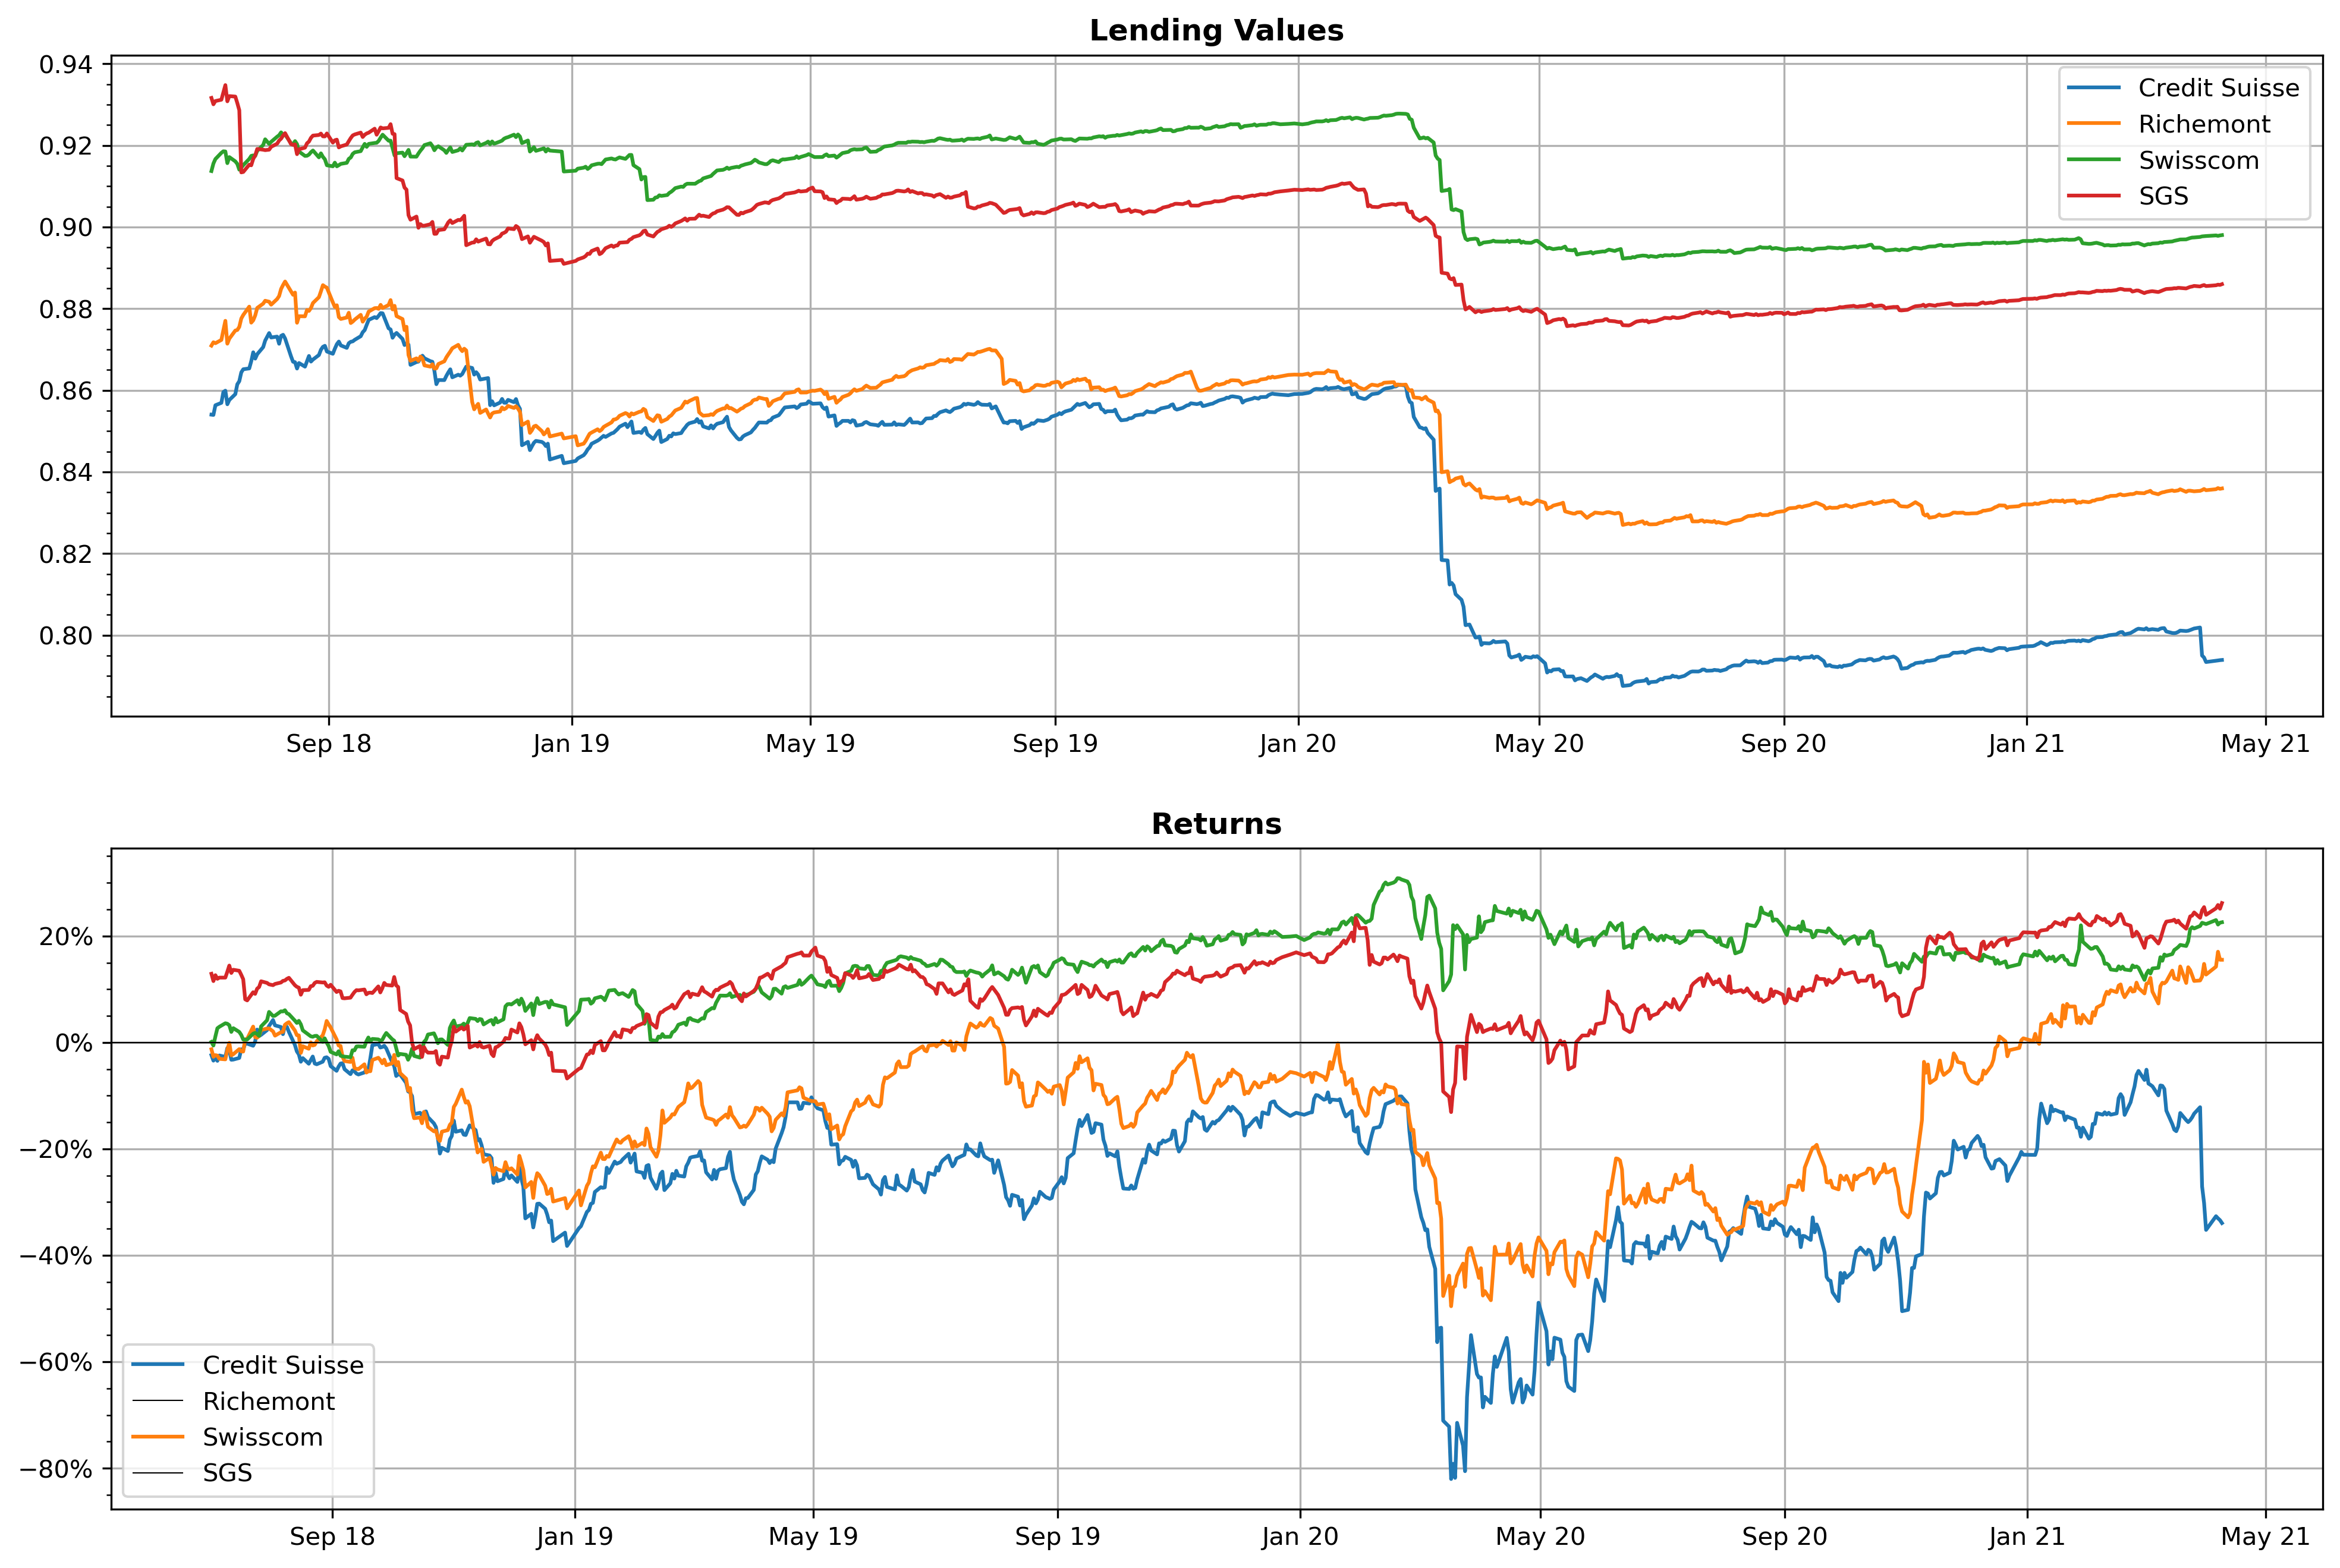

In [6]:
f_lvs, ax = plt.subplots(2,1,figsize=[16,9*1.2],dpi=300)

for i in range(4):
    ax[0].plot(LV_series(selected_logs.iloc[:,i])[60:],lw=1.5)
    ax[0].set_title('Lending Values',fontweight='bold')
for i in range(4):
    ax[1].plot(compounded(selected_logs.iloc[:,i])[60:]*100,lw=1.5)
    ax[1].axhline(0,color='k',lw=0.5)
    ax[1].set_title('Returns',fontweight='bold')
ax[1].yaxis.set_major_formatter(ticker.PercentFormatter())

for i in range(2):
    ax[i].legend(selected)
    ax[i].yaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax[i].xaxis.set_major_locator(mdates.AutoDateLocator())    
    ax[i].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
    ax[i].grid()

## Backtesting
(assuming constant exposure)

In [7]:
st_date = [2019, 4, 23] # First contact date
st_date2 = [2020, 4, 23] # Second contact date
td_year = 252 # No of trading days in a year

In [8]:
# Functions

def contract_sel_plot(contract_starts_date,contract_days):

    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    alpha = 0.25
    epsilon = 0.01
    delta = 10
    
    cs_h = 1-LV(cs_logs[:start_date],alpha,epsilon,delta)
    rich_h = 1-LV(rich_logs[:start_date],alpha,epsilon,delta)
    scom_h = 1-LV(scom_logs[:start_date],alpha,epsilon,delta)
    sgs_h = 1-LV(sgs_logs[:start_date],alpha,epsilon,delta)
    
    cs_mcthresh = cs_h*alpha
    rich_mcthresh = rich_h*alpha
    scom_mcthresh = scom_h*alpha
    sgs_mcthresh = sgs_h*alpha

    fig, ax = plt.subplots(2,2,
                           figsize=[16,9],dpi=100,
                          constrained_layout=True)

    ax[0,0].plot(compounded_date(cs_logs,start_date,end_date),lw=2)
    ax[0,0].axhline(y=-cs_mcthresh,c='k')
    ax[0,0].axhline(y=-cs_h,c='r')
    ax[0,0].set_title(selected[0],fontweight='bold')

    ax[0,1].plot(compounded_date(rich_logs,start_date,end_date),lw=2)
    ax[0,1].axhline(y=-rich_mcthresh,c='k')
    ax[0,1].axhline(y=-rich_h,c='r')
    ax[0,1].set_title(selected[1],fontweight='bold')

    ax[1,0].plot(compounded_date(scom_logs,start_date,end_date),lw=2)
    ax[1,0].axhline(y=-scom_mcthresh,c='k')
    ax[1,0].axhline(y=-scom_h,c='r')
    ax[1,0].set_title(selected[2],fontweight='bold')

    ax[1,1].plot(compounded_date(sgs_logs,start_date,end_date),lw=2)
    ax[1,1].axhline(y=-sgs_mcthresh,c='k')
    ax[1,1].axhline(y=-sgs_h,c='r')
    ax[1,1].set_title(selected[3],fontweight='bold')

    for i in range(2):
        for j in range(2):
            ax[i,j].yaxis.set_minor_locator(ticker.AutoMinorLocator())
            ax[i,j].xaxis.set_major_locator(mdates.AutoDateLocator())    
            ax[i,j].xaxis.set_major_formatter(mdates.DateFormatter('%b %y'))
            ax[i,j].spines['right'].set_visible(False)
            ax[i,j].spines['top'].set_visible(False)
            ax[i,j].grid()
    
def margincall(logs,contract_starts_date,contract_days):
    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    betab = 1-(1-lv)*0.25
    crit_haircut = 1-betab
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-crit_haircut)]
    return mcstate

def margincall_days(logs,contract_starts_date,contract_days):
    start_date = datetime.datetime(contract_starts_date[0],
                                   contract_starts_date[1],
                                   contract_starts_date[2])
    end_date = start_date+pd.tseries.offsets.BDay(contract_days) 
    
    lv = LV(logs[:start_date],alpha,epsilon,delta)
    betab = 1-(1-lv)*0.25
    crit_haircut = 1-betab
    comp = compounded_date(logs,start_date,end_date)
    mcstate = comp[comp<(-crit_haircut)]
    
    mcstate_dates = len(mcstate)
    freq = mcstate_dates / len(logs[start_date:end_date])
    return mcstate_dates, freq

def defaults(logs,contract_starts_date,contract_days):
    mcd = margincall(logs,contract_starts_date,contract_days)
    n = len(mcd)
    
    mcd = mcd.index
    mcd.freq = None

    td = pd.tseries.offsets.BDay(9)
    
    default = []
    for i in range(n):
        cons_bdays = pd.bdate_range(mcd[i],mcd[i]+td)
        cons_bdays.freq = None

        mcd = [i for i in mcd]
        cons_bdays = [i for i in cons_bdays]

        df = pd.DataFrame([mcd,
                           cons_bdays]).T
        df.columns = ['MC','Bdays']
        df = pd.concat([df['MC'].shift(-i),
                        df['Bdays']],
                       axis=1)[:10]
        ver = (df['MC'] == df['Bdays']).all()
        default.append(ver)

    return default

def loan_default(logs,contract_starts_date,contract_days):
    default = defaults(logs,contract_starts_date,contract_days)
    
    if np.array(default).any() == True:
        return 1
    else:
        return 0

def default_date(logs,contract_starts_date,contract_days):
    td = pd.tseries.offsets.BDay(9)
    if loan_default(logs,contract_starts_date,contract_days) == 1:
        d = [int(i) for i in defaults(logs,contract_starts_date,contract_days)]
        mc = [i for i in margincall(logs,contract_starts_date,contract_days).index]
        df = pd.DataFrame([mc,d]).T
        default = df[df[1] == 1].iloc[0,0]
        default_date = default + td
        default_date = default_date.strftime('%d %b %Y')
        return default_date
    else:
        return '-'
    
def default_df(contract_starts_date,contract_days):
    mc = []
    ff = []
    defaul = []
    ddate = []
    for i in range(4):
        mcd = margincall_days(selected_logs.iloc[:,i],
                              contract_starts_date,
                              contract_days)[0]
        mc.append(mcd)
        
        f = margincall_days(selected_logs.iloc[:,i],
                              contract_starts_date,
                              contract_days)[1]
        ff.append(f)

        d = loan_default(selected_logs.iloc[:,i],
                         contract_starts_date,
                         contract_days)
        defaul.append(d)

        dd = default_date(selected_logs.iloc[:,i],
                          contract_starts_date,
                          contract_days)
        ddate.append(dd)
        
    ff = np.array(ff).round(2)
    
    df = pd.DataFrame([mc,ff,defaul,ddate]).T
    df.index = selected
    df.columns = ['# of days in MC state','Frequency','Default','Default Date']
    return df

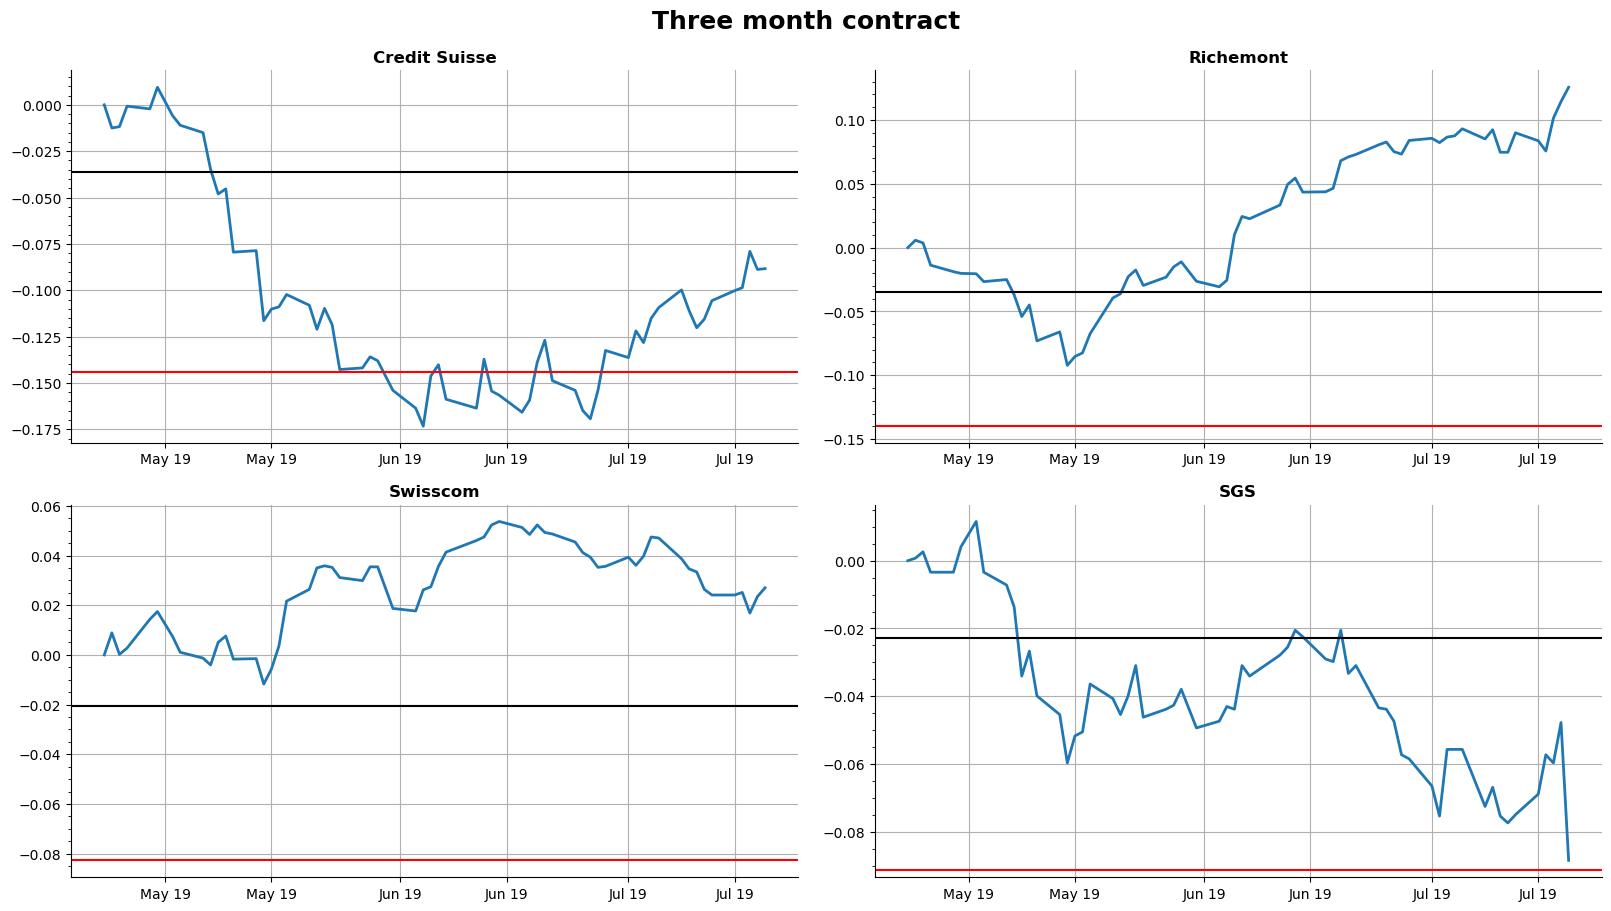

In [9]:
contract_sel_plot(st_date,td_year/4)
_ = plt.suptitle('Three month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/3m_loan.png')

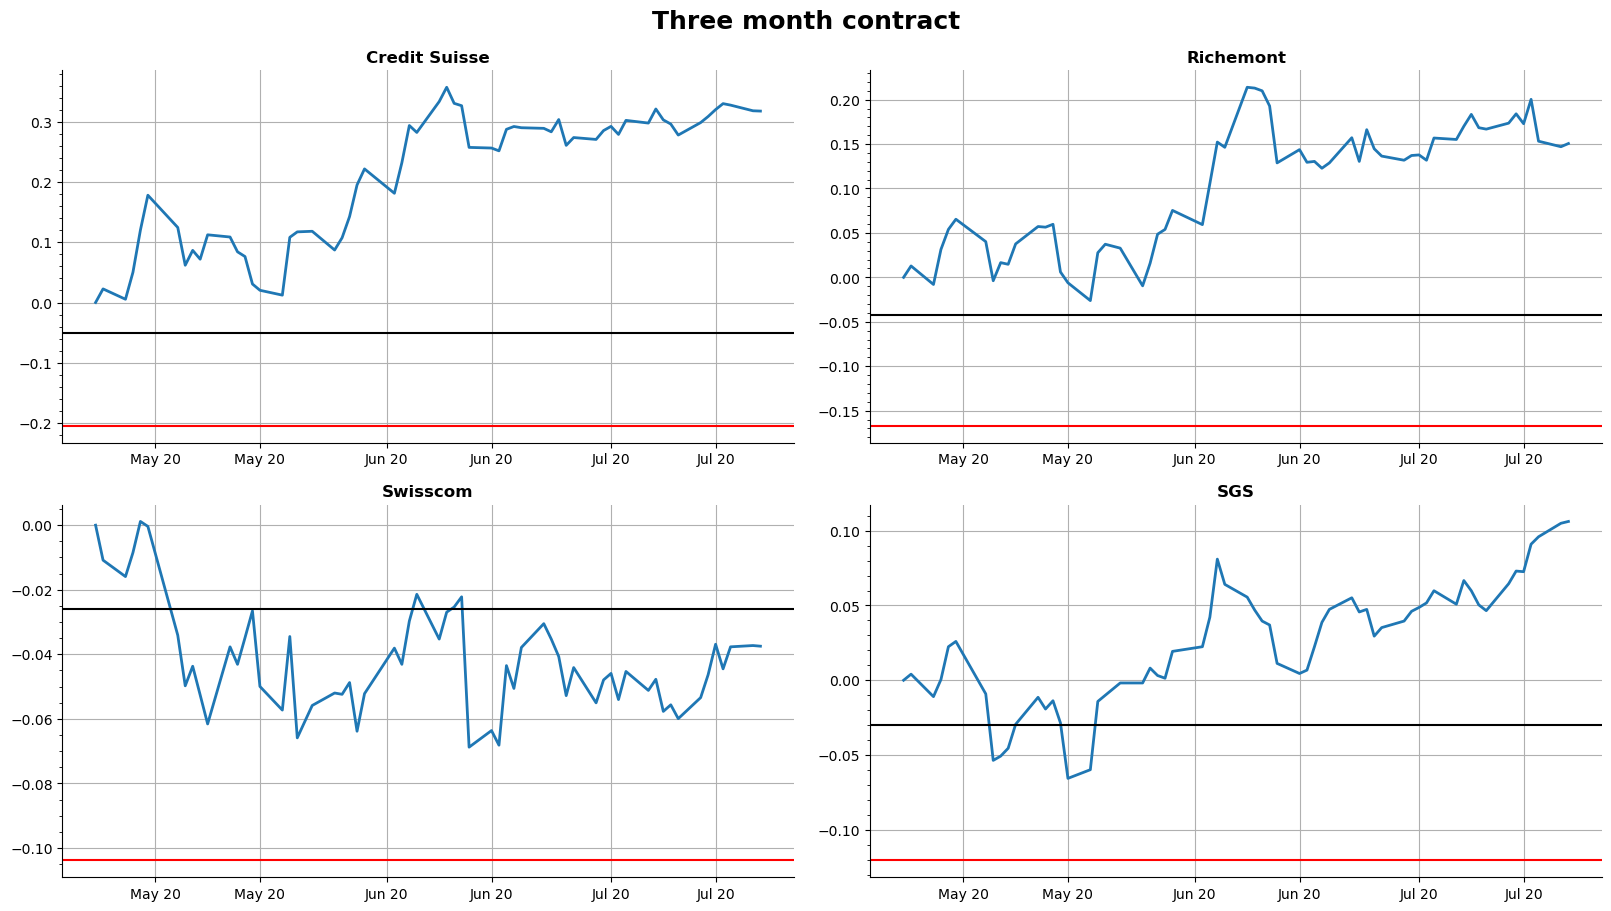

In [10]:
contract_sel_plot(st_date2,td_year/4)
_ = plt.suptitle('Three month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/3m_loan2.png')

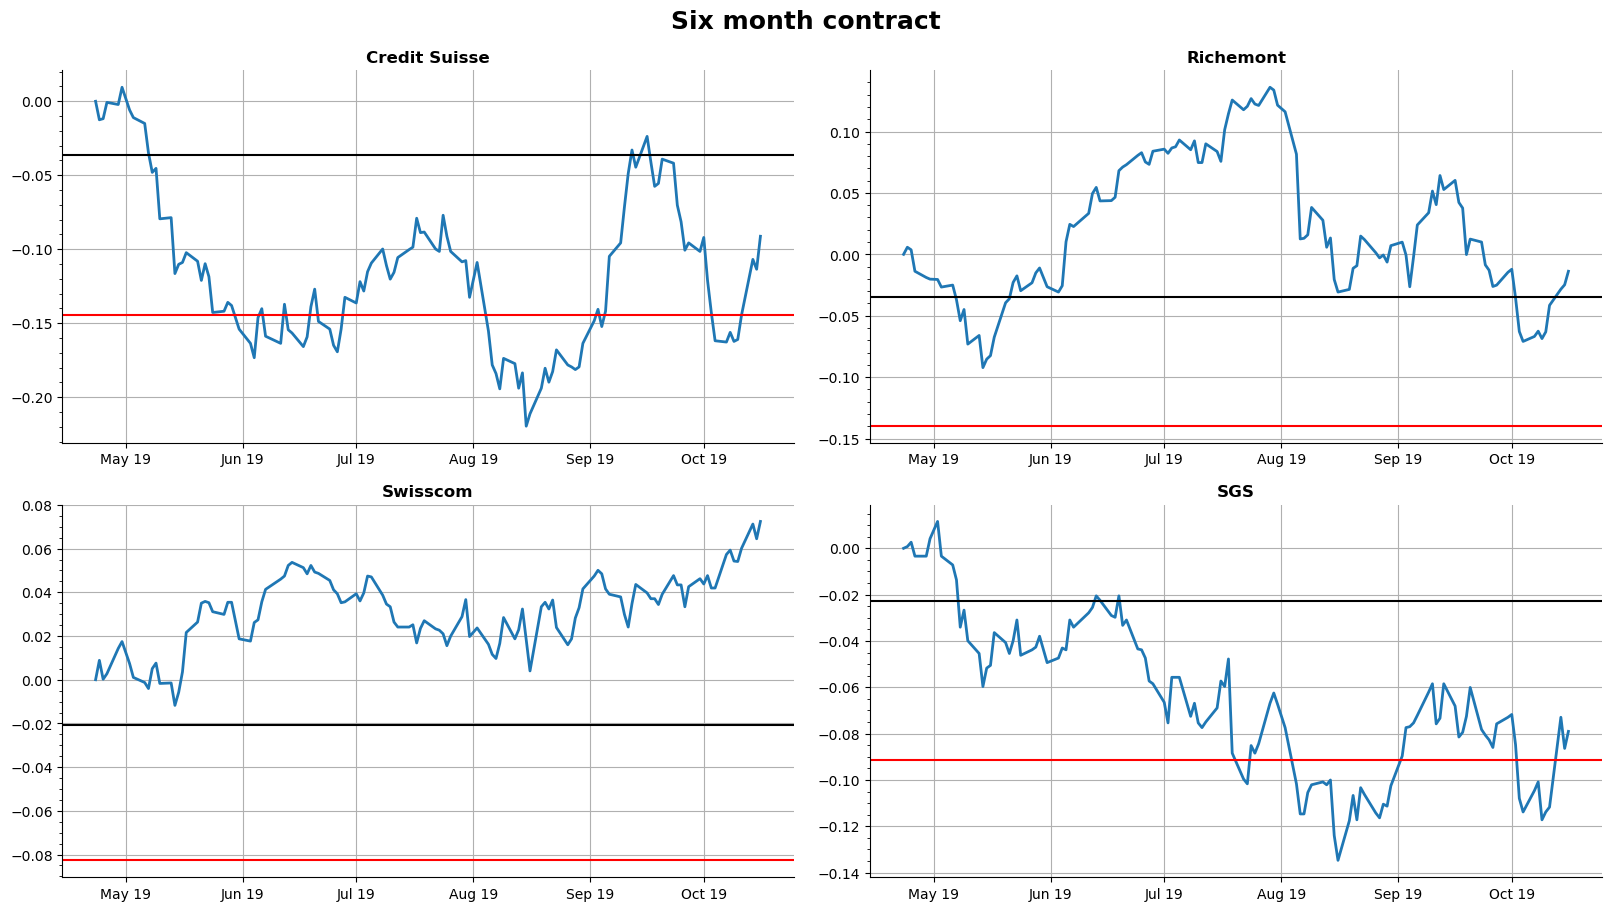

In [11]:
contract_sel_plot(st_date,td_year/2)
_ = plt.suptitle('Six month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/6m_loan.png')

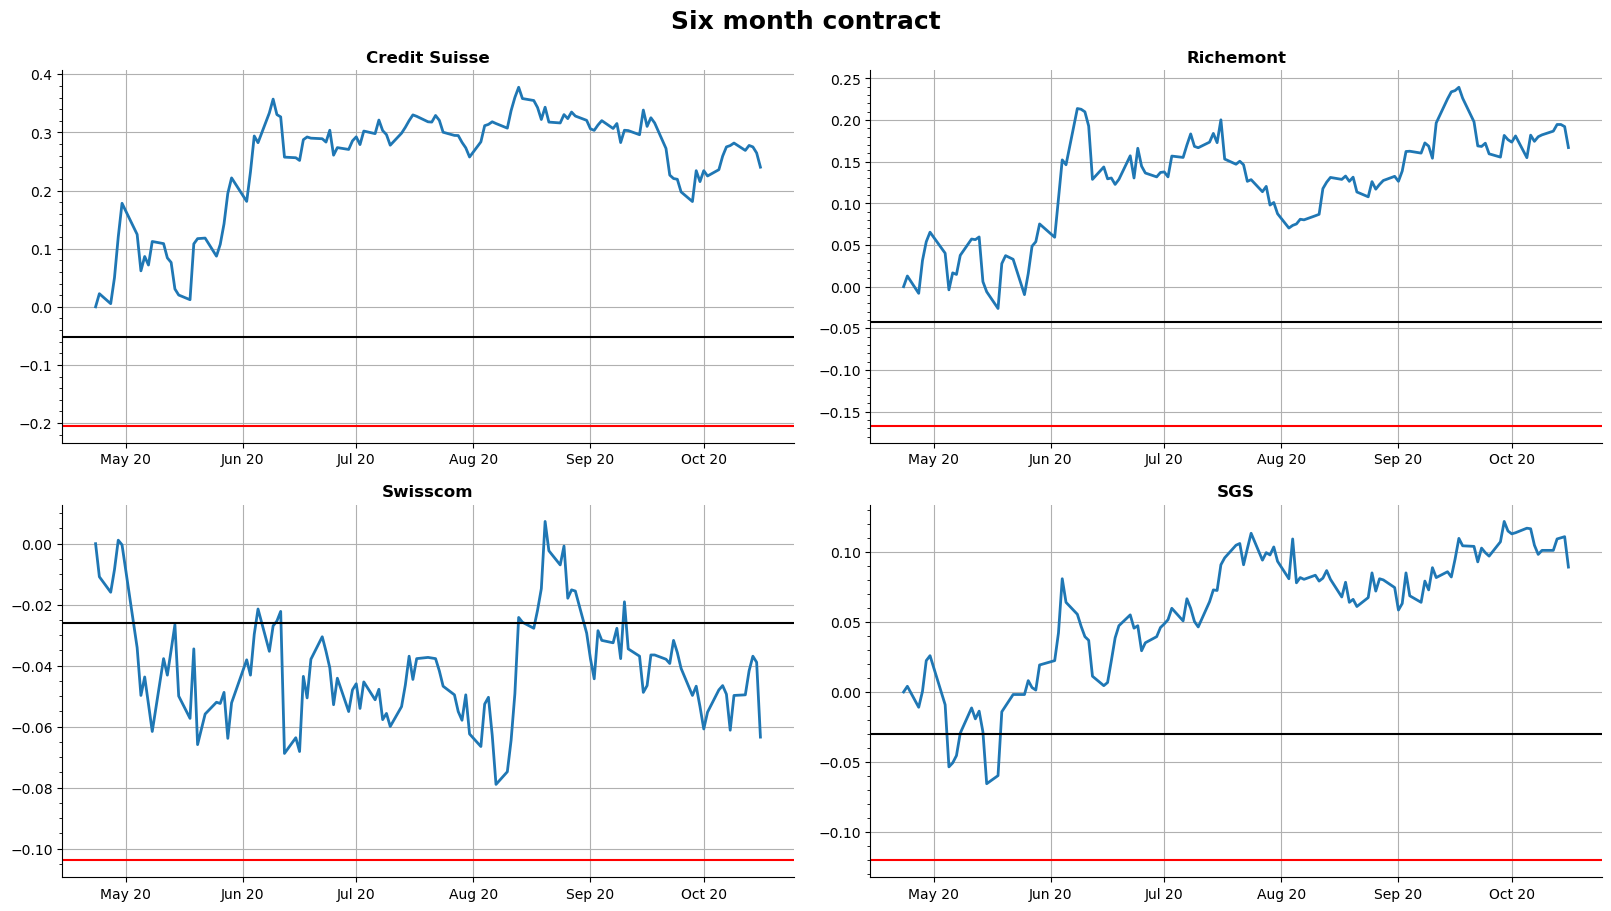

In [12]:
contract_sel_plot(st_date2,td_year/2)
_ = plt.suptitle('Six month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/6m_loan2.png')

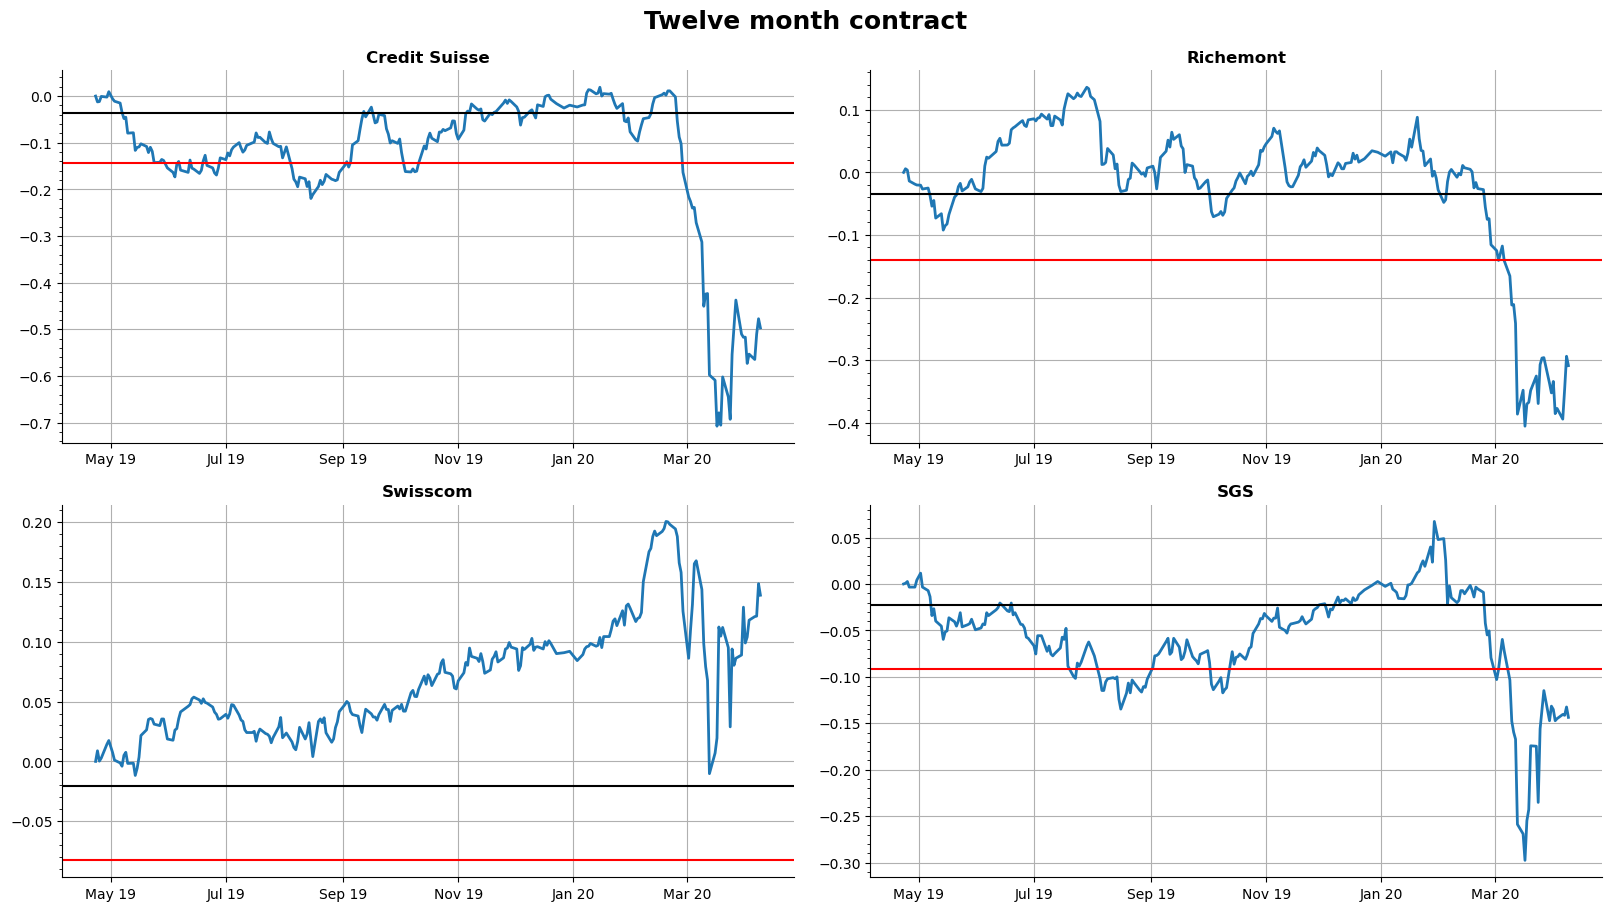

In [13]:
contract_sel_plot(st_date,td_year)
_ = plt.suptitle('Twelve month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/12m_loan.png')

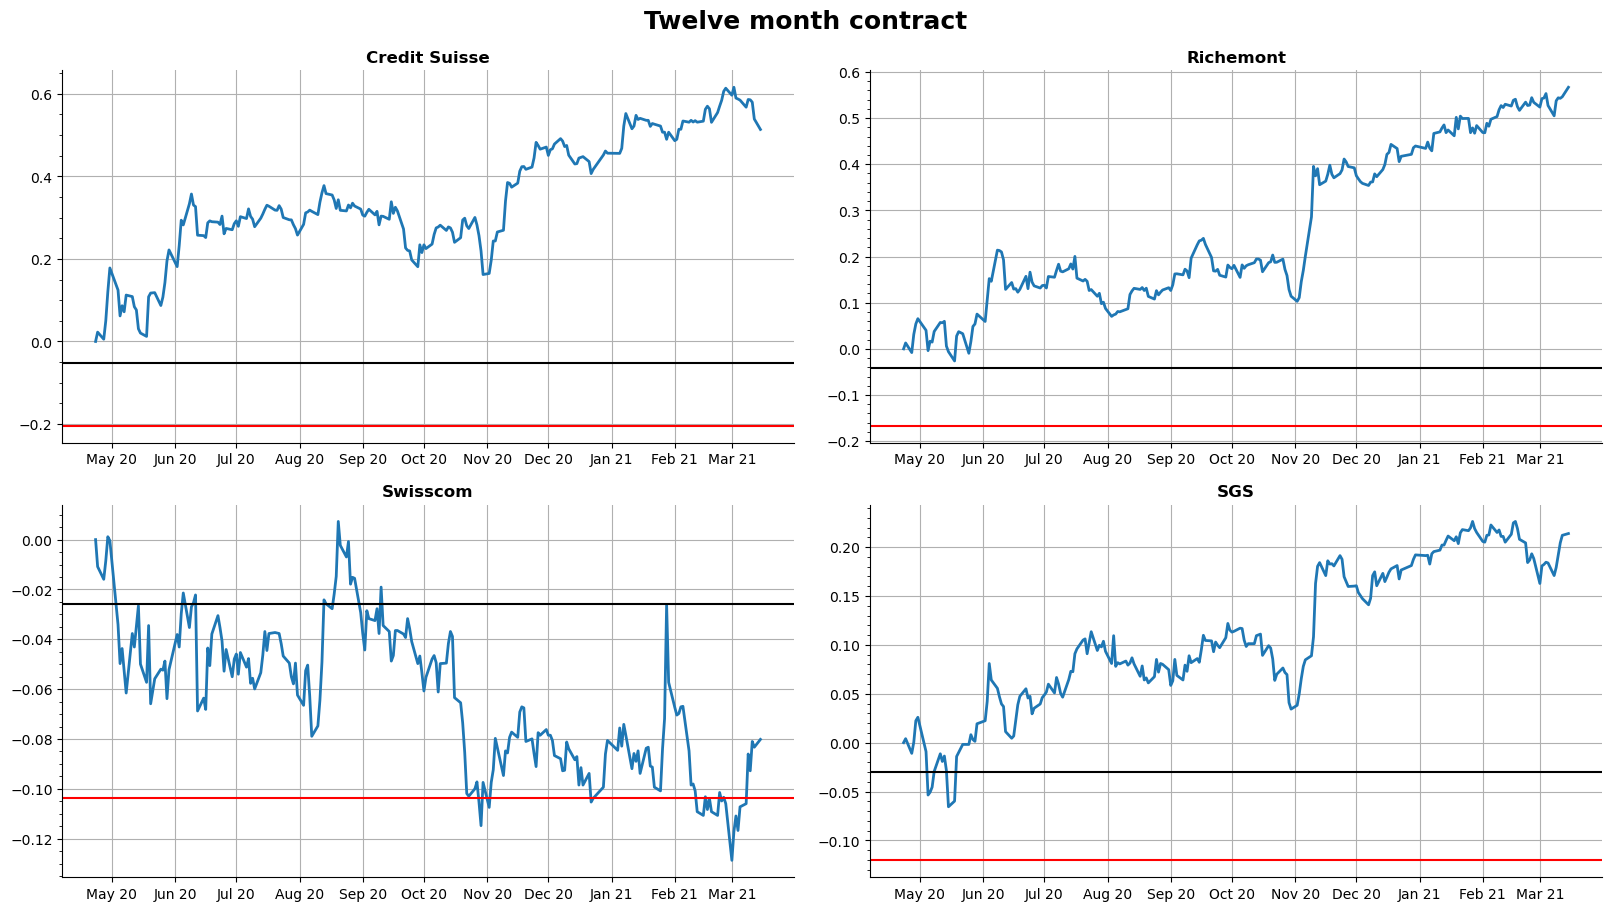

In [14]:
contract_sel_plot(st_date2,td_year-20)
_ = plt.suptitle('Twelve month contract',fontweight='bold',fontsize=18)
plt.savefig('output/figures/12m_loan2.png')

In [15]:
default_3m = default_df(st_date,td_year/4)
default_3m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,51,0.84,1,21 May 2019
Richemont,11,0.18,1,20 May 2019
Swisscom,0,0.0,0,-
SGS,48,0.79,1,21 May 2019


In [16]:
default_3m2 = default_df(st_date2,td_year/4)
default_3m2

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,0,0.0,0,-
Richemont,0,0.0,0,-
Swisscom,52,0.85,1,15 May 2020
SGS,5,0.08,0,-


In [17]:
default_6m = default_df(st_date,td_year/2)
default_6m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,111,0.9,1,21 May 2019
Richemont,19,0.15,1,20 May 2019
Swisscom,0,0.0,0,-
SGS,110,0.89,1,21 May 2019


In [18]:
default_6m2 = default_df(st_date2,td_year/2)
default_6m2

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,0,0.0,0,-
Richemont,0,0.0,0,-
Swisscom,103,0.83,1,15 May 2020
SGS,5,0.04,0,-


In [19]:
default_12m = default_df(st_date,td_year)
default_12m

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,178,0.73,1,21 May 2019
Richemont,54,0.22,1,20 May 2019
Swisscom,0,0.0,0,-
SGS,178,0.73,1,21 May 2019


In [20]:
default_12m2 = default_df(st_date2,td_year-20)
default_12m2

,# of days in MC state,Frequency,Default,Default Date
Credit Suisse,0,0.0,0,-
Richemont,0,0.0,0,-
Swisscom,205,0.91,1,15 May 2020
SGS,5,0.02,0,-


In [ ]:
mc_days = pd.concat([default_df(st_date,td_year/4).iloc[:,0],
                     default_df(st_date,td_year/2).iloc[:,0],
                     default_df(st_date,td_year).iloc[:,0]],axis=1)
mc_days.columns = ['Three month loan','Six month loan','One year loan']
mc_days

In [ ]:
mc_days2 = pd.concat([default_df(st_date2,td_year/4).iloc[:,0],
                     default_df(st_date2,td_year/2).iloc[:,0],
                     default_df(st_date2,td_year-20).iloc[:,0]],axis=1)
mc_days2.columns = ['Three month loan','Six month loan','One year loan']
mc_days2

## Adjusted for Liquidity

In [ ]:
a_hat_juri = -1.87096
b_hat_juri = -0.794554

In [ ]:
smi_adtv = ADTV(smi_vols)['ADTV - Last month']
smi_adtv.name = 'ADTV'

In [ ]:
smi_gamma = []
for i in smi_adtv:
    est_i = gamma_est(i,a_hat_juri,b_hat_juri)
    smi_gamma.append(est_i)
smi_gamma = pd.Series(smi_gamma,index=smi_names,name='Gamma')

smi_liq = pd.concat([smi_adtv.round(0).astype(int),
                     smi_gamma],
                    axis=1).sort_values('ADTV',ascending=False)

sel_liq = smi_liq.loc[selected]
sel_liq

In [ ]:
smi_adjlvs_x0 = []
smi_adjlvs_xthousand = []
smi_adjlvs_xmil = []
smi_adjlvs_x2adtv = []

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  0)
    smi_adjlvs_x0.append(adjlv)

for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  10**3)
    smi_adjlvs_xthousand.append(adjlv)
    
for i in range(smi_n):
    adjlv = LV_adj(smi_logs.iloc[:,i],
                   alpha,epsilon,delta,
                   smi_gamma[i],
                  10**6)
    smi_adjlvs_xmil.append(adjlv)
    
# for i in range(smi_n):
#     adjlv = LV_adj(smi_logs.iloc[:,i],
#                    alpha,epsilon,delta,
#                    smi_gamma[i],
#                    smi_adtv[i]*2)
#     smi_adjlvs_x2adtv.append(adjlv)

smi_adjlvs = pd.DataFrame([smi_adjlvs_x0,
                           smi_adjlvs_xthousand,
                           smi_adjlvs_xmil],
                           #smi_adjlvs_x2adtv],
                          index=['x = 0','x = 1 000','x =1 000 000'],#,'x = ADTV x 2'],
                          columns=smi_names).T.sort_values('x = 0',ascending=False).round(2)
smi_adjlvs

In [ ]:
sel_adjlvs =smi_adjlvs.loc[selected]
sel_adjlvs

In [ ]:
# Uncomment the following to get a plot of lending values (for 4 stocks) as a function of x = no. stocks pledged

In [ ]:
# x_range = np.arange(0,10**8,10**3)

In [ ]:
# cs_lvx = lvx(smi_logs.loc[:,'Credit Suisse'],
#              alpha,epsilon,delta,
#              smi_gamma['Credit Suisse'],
#              x_range)
# rich_lvx = lvx(smi_logs.loc[:,'Richemont'],
#              alpha,epsilon,delta,
#              smi_gamma['Richemont'],
#              x_range)
# scom_lvx = lvx(smi_logs.loc[:,'Swisscom'],
#              alpha,epsilon,delta,
#              smi_gamma['Swisscom'],
#              x_range)
# sgs_lvx = lvx(smi_logs.loc[:,'SGS'],
#              alpha,epsilon,delta,
#              smi_gamma['SGS'],
#              x_range)

In [ ]:
# f_lvx ,ax = plt.subplots(1,1,figsize=[16,9],dpi=200)
# ax.plot(x_range,cs_lvx,lw=3)
# ax.plot(x_range,rich_lvx,lw=3)
# ax.plot(x_range,scom_lvx,lw=3)
# ax.plot(x_range,sgs_lvx,lw=3)

# ax.set_xscale('log')
# ax.set_xlabel('No. of stocks')
# ax.set_ylabel('Lending Value')
# ax.legend(selected)
# ax.spines['right'].set_visible(False)
# ax.spines['top'].set_visible(False)
# ax.grid()
# plt.tight_layout()

In [ ]:
# # Export

# smi_lvs.to_latex('output/results/smi_lvs')
# sel_lvs.to_latex('output/results/sel_lvs')

# smi_adjlvs.to_latex('output/results/smi_adjlvs')
# sel_adjlvs.to_latex('output/results/sel_adjlvs')

# sel_liq.to_latex('output/results/sel_liq')

# default_3m.to_latex('output/results/default_3m')
# default_6m.to_latex('output/results/default_6m')
# default_12m.to_latex('output/results/default_12m')
# mc_days.to_latex('output/results/mc_days')

# default_3m2.to_latex('output/results/default_3m2')
# default_6m2.to_latex('output/results/default_6m2')
# default_12m2.to_latex('output/results/default_12m2')
# mc_days2.to_latex('output/results/mc_days2')

# f_lvs.savefig('output/figures/lvs.png')
# f_lvx.savefig('output/figures/lvx.png')